In [2]:
import re
import jsonlines
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## DDXPlus Plot

In [3]:
LABEL2TEXT = {
    0: 'Acute COPD exacerbation / infection',
    1: 'Acute dystonic reactions',
    2: 'Acute laryngitis',
    3: 'Acute otitis media',
    4: 'Acute pulmonary edema',
    5: 'Acute rhinosinusitis',
    6: 'Allergic sinusitis',
    7: 'Anaphylaxis',
    8: 'Anemia',
    9: 'Atrial fibrillation',
    10: 'Boerhaave',
    11: 'Bronchiectasis',
    12: 'Bronchiolitis',
    13: 'Bronchitis',
    14: 'Bronchospasm / acute asthma exacerbation',
    15: 'Chagas',
    16: 'Chronic rhinosinusitis',
    17: 'Cluster headache',
    18: 'Croup',
    19: 'Ebola',
    20: 'Epiglottitis',
    21: 'GERD',
    22: 'Guillain-Barré syndrome',
    23: 'HIV (initial infection)',
    24: 'Influenza',
    25: 'Inguinal hernia',
    26: 'Larygospasm',
    27: 'Localized edema',
    28: 'Myasthenia gravis',
    29: 'Myocarditis',
    30: 'PSVT',
    31: 'Pancreatic neoplasm',
    32: 'Panic attack',
    33: 'Pericarditis',
    34: 'Pneumonia',
    35: 'Possible NSTEMI / STEMI',
    36: 'Pulmonary embolism',
    37: 'Pulmonary neoplasm',
    38: 'SLE',
    39: 'Sarcoidosis',
    40: 'Scombroid food poisoning',
    41: 'Spontaneous pneumothorax',
    42: 'Spontaneous rib fracture',
    43: 'Stable angina',
    44: 'Tuberculosis',
    45: 'URTI',
    46: 'Unstable angina',
    47: 'Viral pharyngitis',
    48: 'Whooping cough'
}
TEXT2LABEL = {v: k for k, v in LABEL2TEXT.items()}

def postprocess_generation(res: str) -> int:
    NOTINLABEL = len(LABEL2TEXT)
    res = res.lower().strip()
    # Search for the pattern <number>. <diagnosis> using `re`, and extract <number>
    numbers = re.findall(pattern=r"(\d+)\.", string=res)
    if len(numbers) == 1:
        number = int(numbers[0])
        if number in LABEL2TEXT:
            prediction = number
        else:
            # print(f"Prediction {res} not found in the label set.")
            prediction = NOTINLABEL
    else:
        if len(numbers) > 1:
            # print(f"Extracted numbers {numbers} is not exactly one. Select the first one.")
            prediction = int(numbers[0])
        else:
            # print(f"Prediction {res} has no extracted numbers. Use self.NOTINLABEL")
            prediction = NOTINLABEL
    return prediction

def read_jsonl(fp: str) -> list[dict]:
    with jsonlines.open(fp) as f:
        rows = list(f)
    return rows

def extract_pred_label(rows: list[dict], subset: list[int] = None) -> tuple[list[int], list[int]]:
    y_true = [TEXT2LABEL[row['label_text']] for row in rows]
    y_pred = [postprocess_generation(row['output_pred']) for row in rows]
    if subset:
        subset = set(subset)
        y_true_subset = list()
        y_pred_subset = list()
        for true, pred in zip(y_true, y_pred):
            if true in subset:
                y_true_subset.append(true)
                if pred not in subset:
                    pred = max(subset) + 1
                y_pred_subset.append(pred)
        return y_true_subset, y_pred_subset
    return y_true, y_pred

def calc_acc(y_true: list[int], y_pred: list[int]) -> float:
    return sum([1 for yt, yp in zip(y_true, y_pred) if yt == yp]) / len(y_true)

## Performance Curve

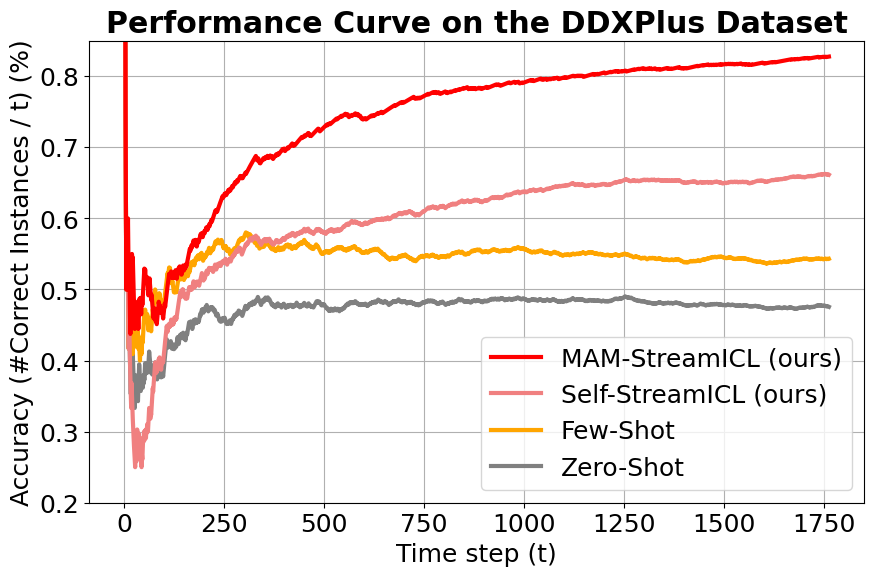

In [4]:
method2jsonl = {
    "Zero-Shot": "/home/brianckwu/stream-bench/log/ddxplus/test/ZeroShotAgent__openai__gpt-3.5-turbo-0125.jsonl",
    "Few-Shot": "/home/brianckwu/stream-bench/log/ddxplus/test/FewShotAgent__openai__gpt-3.5-turbo-0125.jsonl",
    "Self-StreamICL (ours)": "/home/brianckwu/stream-bench/log/ddxplus/test/gt_correctness_self_fewshot_rag__openai__gpt-3.5-turbo-0125__bge-base-en-v1.5__similar_at_bottom__16.jsonl",
    "MAM-StreamICL (ours)": "/home/brianckwu/stream-bench/log/ddxplus/test/ma_ts__gpt-3.5-turbo-0125_gemini-1.0-pro_claude-3-haiku-20240307__bge-base-en-v1.5__similar_at_bottom__16__warmup-0.jsonl"
}

llm2rows = {
    llm: read_jsonl(fp) for llm, fp in method2jsonl.items()
}

llm2pred_labels = {
    llm: extract_pred_label(rows) for llm, rows in llm2rows.items()
}

llm2correct_per_step = {
    llm: [1 if yt == yp else 0 for yt, yp in zip(*pred_labels)] for llm, pred_labels in llm2pred_labels.items()
}  # {method_1: [1, 0, 1, 1, 0, ...], method_2: [0, 1, 1, 0, ...], ...}

# Plot
# Calculate average accuracy over time steps for streaming methods
# Set the axis's font to 14
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3})
llm2avg_accuracy = {llm: [sum(llm2correct_per_step[llm][:i+1]) / (i+1) for i in range(len(llm2correct_per_step[llm]))] for llm in llm2correct_per_step}


# Plot
plt.figure(figsize=(10, 6))
plt.gca().set_ylim([0.2, 0.85])

# # Calculate average accuracy for non-streaming methods
# zero_shot_avg = sum(llm2correct_per_step["Zero-Shot"]) / len(llm2correct_per_step["Zero-Shot"])
# few_shot_avg = sum(llm2correct_per_step["Few-Shot"]) / len(llm2correct_per_step["Few-Shot"])
# # Plot non-streaming methods as horizontal dotted lines
# plt.axhline(zero_shot_avg, color='grey', linestyle='--', label='Zero-Shot')
# plt.axhline(few_shot_avg, color='black', linestyle='--', label='Few-Shot')

# Plot streaming methods
for method, color in zip(["Zero-Shot", "Few-Shot", "Self-StreamICL (ours)", "MAM-StreamICL (ours)"], ['grey', 'orange', 'lightcoral', 'red']):
    plt.plot(llm2avg_accuracy[method], color=color, label=method)

plt.title('Performance Curve on the DDXPlus Dataset', fontweight='bold')
plt.xlabel('Time step (t)')
plt.ylabel('Accuracy (#Correct Instances / t) (%)')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="lower right")
plt.grid(True)
plt.savefig(f'perf_curve_ddxplus.png', dpi=500, bbox_inches='tight')
plt.show()

## Confusion Matrix

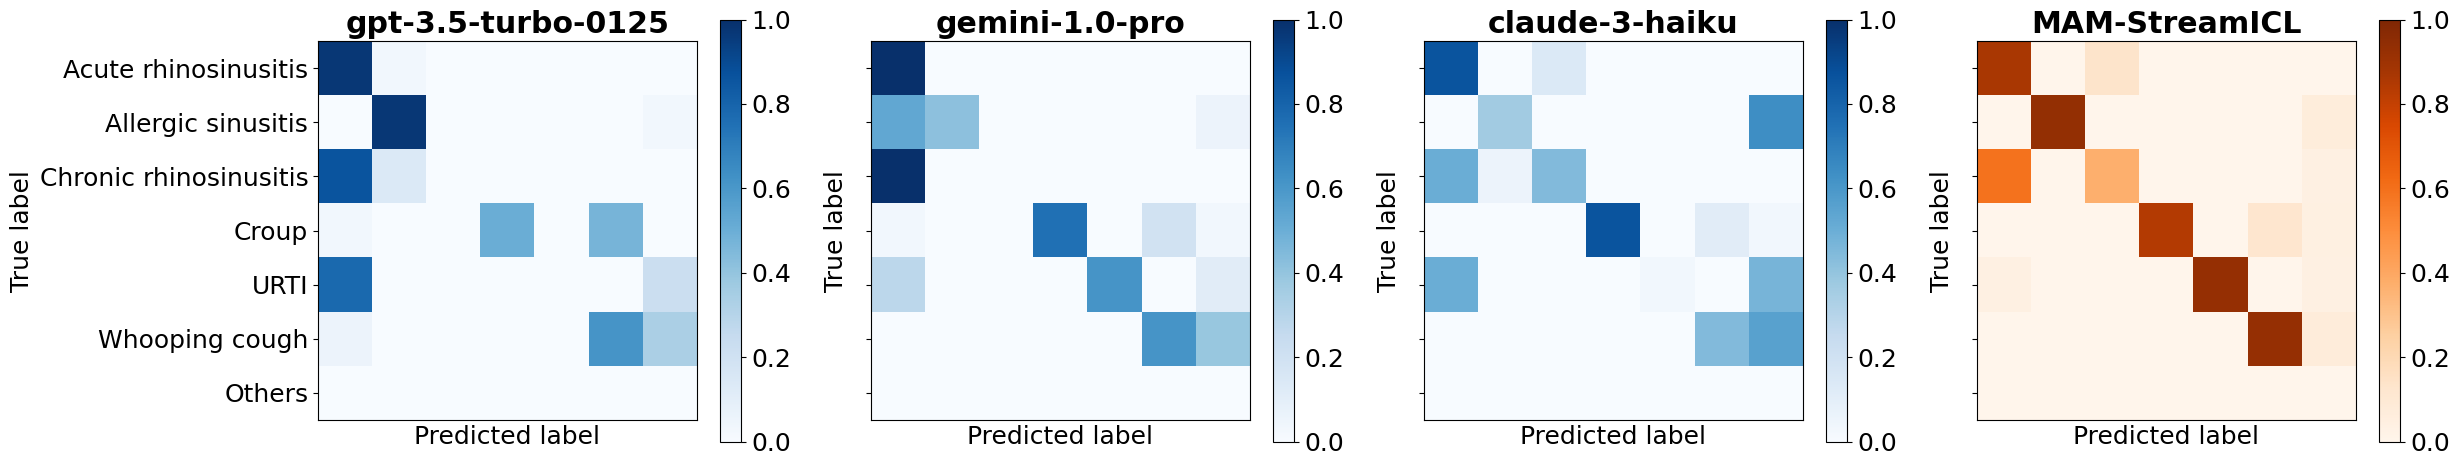

In [9]:
jsonl_dict = {
    "gpt-3.5-turbo-0125": "/home/brianckwu/stream-bench/log/ddxplus/test/ZeroShotAgent__openai__gpt-3.5-turbo-0125.jsonl",
    "gemini-1.0-pro": "/home/brianckwu/stream-bench/log/ddxplus/test/ZeroShotAgent__gemini_dev__gemini-1.0-pro.jsonl",
    "claude-3-haiku": "/home/brianckwu/stream-bench/log/ddxplus/test/ZeroShotAgent__anthropic__claude-3-haiku-20240307.jsonl",
    "MAM-StreamICL": "/home/brianckwu/stream-bench/log/ddxplus/test/ma_ts__gpt-3.5-turbo-0125_gemini-1.0-pro_claude-3-haiku-20240307__bge-base-en-v1.5__similar_at_bottom__16.jsonl"
}

llm2rows = {
    llm: read_jsonl(fp) for llm, fp in jsonl_dict.items()
}

subset = [5, 6, 16, 18, 45, 48]
display_subset = [LABEL2TEXT[label] for label in subset] + ["Others"]
llm2pred_labels = {
    llm: extract_pred_label(rows, subset) for llm, rows in llm2rows.items()
}

# Create a figure with 1 row and 3 columns
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

# Plot confusion matrices for all 3 models, without displaying the numbers
for i, (ax, (llm, (y_true, y_pred))) in enumerate(zip(axes, llm2pred_labels.items())):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # labels=range(len(LABEL2TEXT))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_subset if i == 0 else [' '] * len(display_subset)) #, display_labels=LABEL2TEXT.values())
    disp.plot(include_values=False, xticks_rotation='vertical', values_format='.2f', cmap='Blues' if i < 3 else "Oranges", ax=ax, im_kw={'vmin': 0, 'vmax': 1})
    ax.set_title(llm, fontweight="bold")
    ax.set_xticks([])
    # ax.set_yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Save figure with high dpi (crop the white space)
fig.savefig('./confusion_matrix.pdf', dpi=500, bbox_inches='tight')

## HotpotQA

In [37]:
from datasets import load_dataset

In [35]:
hqa = load_dataset("hotpot_qa", "distractor")
rows = hqa["validation"]

In [36]:
from collections import Counter

Counter(rows["level"])

Counter({'hard': 7405})

In [16]:
row = rows[4]
row["supporting_facts"]["title"], row["context"] #["sentences"]

(['Big Stone Gap (film)', 'Adriana Trigiani'],
 {'title': ['Just Another Romantic Wrestling Comedy',
   'Kingston Morning',
   'Nola (film)',
   'Adriana Trigiani',
   'Great Eastern Conventions',
   'New York Society of Model Engineers',
   'Clinton, Minnesota',
   "Hamish and Andy's Gap Year",
   'I Love NY (2015 film)',
   'Big Stone Gap (film)'],
  'sentences': [['Just Another Romantic Wrestling Comedy is a 2006 film starring April Hunter and Joanie Laurer.',
    ' This Romantic comedy film was premiered at New Jersey and New York City on December 1, 2006 and was released on DVD in the United States and the United Kingdom on April 17, 2007.',
    ' After the film\'s DVD release "Just Another Romantic Wrestling Comedy" won an "Honorable Mention" award at the New Jersey International Festival awards.',
    ' The release is being handled by "Victory Multimedia".'],
   ["Kingston Morning is Dave Eggar's 4th solo release recorded in Brooklyn, New York; Kingston, Jamaica; and Big Stone G

In [ ]:
row["supporting_facts"]

In [ ]:
row["context"]

In [27]:
import evaluate

In [32]:
em = evaluate.load("exact_match")
f1 = evaluate.load("f1")

In [ ]:
preds = ["apple", "Banana"]
labels = ["Apple", "Banana"]

em.compute()

f1.compute(predictions=preds, references=labels)